### Image segmentation using Unet Architecture

In [ ]:
import glob
import numpy as np
import nibabel as nib
import pydicom
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Add
import tensorflow.keras.models as models
from tensorflow.keras.initializers import orthogonal
from tensorflow.keras.optimizers import Adam
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
os.getcwd()

'/content'

In [ ]:
from pathlib import Path
path = 'your path'
os.chdir(path)
folders_list = os.listdir(path+'/CT')

In [ ]:
def normalize(x):
    div = 1 if np.max(x) == 0 else (np.max(x)-np.min(x))
    x = (x-np.min(x)) / div
    return x

In [ ]:
total_dcms = []
total_gts = []
import cv2
import pandas as pd
paths_df = pd.DataFrame(columns = ['dcm_path', 'gt_path'])
for folder in folders_list:
#for folder in ['27']:
    path_1 = os.path.join(os.getcwd(), 'your path', folder)
    path_1_CT_folder = os.listdir(os.path.join(path_1, 'DICOM_anon'))
    path_1_GT_folder = os.listdir(os.path.join(path_1, 'Ground'))
    paths_CT = [str(os.path.join(path_1, 'DICOM_anon', i)) for i in path_1_CT_folder]
    paths_GT = [str(os.path.join(path_1, 'Ground', j)) for j in path_1_GT_folder]
    
    paths_CT.sort()
    paths_GT.sort()
    
    #print(folder, len(paths_CT), len(paths_GT)) 
    paths_df = paths_df.append(pd.DataFrame({'dcm_path':paths_CT, 'gt_path':paths_GT}), ignore_index = True)

In [ ]:
pd.set_option('display.max_colwidth', None)
paths_df.iloc[300:305]

In [ ]:
import matplotlib.pyplot as plt
data_dcms = []
data_gts = []

ignore = []
for index, row in paths_df.iterrows():
    sample_ct = pydicom.dcmread(row['dcm_path']).pixel_array
    sample_ct_normalized = normalize(sample_ct)
    data_dcms.append(sample_ct_normalized)
    sample_gt = cv2.imread(row['gt_path'], 0)
    sample_gt_normalized = normalize(sample_gt)
    data_gts.append(sample_gt_normalized)


In [ ]:
data_dcms = np.asarray(data_dcms)
data_gts = np.asarray(data_gts)

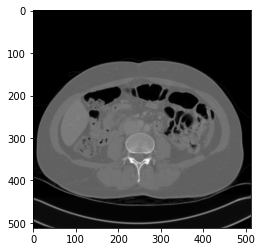

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_dcms[970,:,:], cmap='gray')

In [ ]:
data_gts = np.concatenate((data_gts_01, data_gts_02), axis=0)
data_gts.shape

(972, 512, 512)

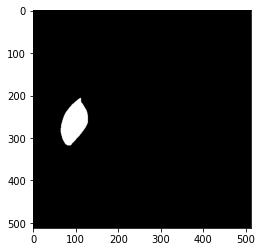

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(data_gts[970,:,:], cmap='gray')

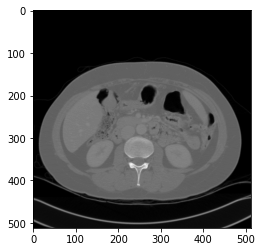

In [ ]:
test_samples = data_dcms[950:,:,:]
test_samples.shape
plt.imshow(test_samples[0,:,:], cmap='gray')

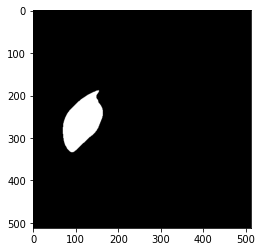

In [ ]:
test_gts = data_gts[950:,:,:]
test_gts.shape
plt.imshow(test_gts[0,:,:], cmap='gray')

In [ ]:
data_dcms = data_dcms[0:950,:,:]
data_gts = data_gts[0:950,:,:]

In [ ]:
print('dcms shape',data_dcms.shape)
print('gts shape', data_gts.shape)

dcms shape (950, 512, 512)
gts shape (950, 512, 512)


In [ ]:
data_dcms = np.expand_dims(data_dcms, axis=-1)
data_gts = np.expand_dims(data_gts, axis=-1)

In [ ]:
print(f"shape of dicom data: {data_dcms.shape}")
print(f"shape of groud truth data: {data_gts.shape}")

shape of dicom data: (950, 512, 512, 1)
shape of groud truth data: (950, 512, 512, 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_dcms, data_gts , test_size=0.2)

In [ ]:
print(f"X_train shape is {X_train.shape}")
print(f"X_test shape is {X_test.shape}")
print(f"y_train shape is {y_train.shape}")
print(f"y_test shape is {y_test.shape}")

X_train shape is (760, 512, 512, 1)
X_test shape is (190, 512, 512, 1)
y_train shape is (760, 512, 512, 1)
y_test shape is (190, 512, 512, 1)


In [ ]:
def ConvolutionLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'

    x = layers.Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)

    #x = layers.MaxPooling2D(pool_size=(2,2), strides=(1,1))(x)

    x = layers.ReLU(name=prefix+'relu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

In [ ]:
def upsamplingLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'

    x = layers.Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)

    x = layers.ReLU(name=prefix+'relu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

In [ ]:
def segModel(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    #downsample

    conv1 = ConvolutionLayer(inputs, 64, 3, strides=1, padding='same', block_id=1)

    mp = layers.MaxPooling2D(pool_size=(2,2), strides=(1,1))

    mp1 = mp(conv1)

    conv2 = ConvolutionLayer(mp1, 64, 3, strides=2, padding='same', block_id=2)

    conv3 = ConvolutionLayer(conv2, 128, 5, strides=2, padding='same', block_id=3)

    mp2 = layers.MaxPooling2D(pool_size=(2,2), strides=(1,1))

    mp3 = mp(conv3)

    conv4 = ConvolutionLayer(mp3, 128, 3, strides=1, padding='same', block_id=4)
    
    conv5 = ConvolutionLayer(conv4, 256, 5, strides=2, padding='same', block_id=5)
    
    conv6 = ConvolutionLayer(conv5, 512, 3, strides=2, padding='same', block_id=6)
    
    
    #upsampling including convolution operation (plus skip connections)
    upsamp1 = upsamplingLayer(conv6, 512, 3, strides=2, padding='same', block_id=7)
    
    skip1 = layers.concatenate([upsamp1, conv5], name = 'skip_1')
    
    conv7 = ConvolutionLayer(skip1, 256, 3, strides=1, padding='same', block_id=8)
    
    upsamp2 = upsamplingLayer(conv7, 128, 3, strides=2, padding='same', block_id=9)
    
    skip2 = layers.concatenate([upsamp2, conv3], name='skip_2')
    
    conv8 = ConvolutionLayer(skip2, 128, 5, strides=1, padding='same', block_id=10)
    
    upsamp3 = upsamplingLayer(conv8, 64, 3, strides=2, padding='same', block_id=11)
    
    skip3 = layers.concatenate([upsamp3, conv2], name='skip_3')
    
    conv9 = ConvolutionLayer(skip3, 64, 5, strides=1, padding='same', block_id=12)
    
    upsamp4 = upsamplingLayer(conv9, 64, 3, strides=2, padding='same', block_id=13)
    
    skip4 = layers.concatenate([upsamp4, conv1], name='skip_4')

    #mp2 = layers.MaxPooling2D(pool_size=(2,2), strides=(1,1))

    #mp3 = mp2(skip4)
    
    conv10 = layers.Conv2D(1, 3, strides=1, padding='same', activation='sigmoid',
                       kernel_initializer=orthogonal(), name='final_conv')(skip4)

    return models.Model(inputs=inputs, outputs=conv10)

In [ ]:
from keras import backend as K
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f + K.sum(y_pred_f))+ smooth)

Using TensorFlow backend.


In [ ]:
input_shape =  (512, 512)  # shape of the sample
model = segModel((*input_shape, 1))
model_optimizer = Adam(learning_rate=0.002)

In [ ]:
#def meaniou():
#  return tf.keras.metrics.MeanIoU(num_classes=2)
meaniou = tf.keras.metrics.MeanIoU(num_classes=2)
model.compile(optimizer=model_optimizer, loss='binary_crossentropy', metrics=[meaniou])#
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
block_1_conv (Conv2D)           (None, 512, 512, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
block_1_relu (ReLU)             (None, 512, 512, 64) 0           block_1_conv[0][0]               
__________________________________________________________________________________________________
block_1_drop (Dropout)          (None, 512, 512, 64) 0           block_1_relu[0][0]               
______________________________________________________________________________________________

In [ ]:
Path_MODELSAVE = 'saved_models_mou_05'
Path_LOGS = 'logs_mou_05'
for i in [Path_MODELSAVE, Path_LOGS]:
    if i not in os.listdir(os.getcwd()):
        os.mkdir(i)

In [ ]:
epochs = 500
batch_size = 20
saved_weight = os.path.join(Path_MODELSAVE, 'dataweights.{epoch:02d}-{meaniou:.2f}.hdf5')

In [ ]:
with tf.device('/device:GPU:0'):
    saved_weight = os.path.join(Path_MODELSAVE, 'dataweights.{epoch:002d}.hdf5')
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(saved_weight,
                                       save_weights_only=True,
                                       mode='auto',
                                       period=50,
                                       save_freq='epoch')
    tensorboard = tf.keras.callbacks.TensorBoard(log_dir=Path_LOGS,
                                            histogram_freq=0,
                                            write_graph=True,
                                            write_images=True)
    csv_logger = tf.keras.callbacks.CSVLogger(f'{Path_LOGS}/keras_log.csv' ,append=True)

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
            validation_data=(X_test, y_test), 
            callbacks=[tensorboard, csv_logger, model_checkpoint])
    
    #model.save('saved_models/segementation.hdf5')

Epoch 1/500
38/38 [==============================] - 35s 494ms/step - loss: 0.4297 - mean_io_u: 0.4607 - val_loss: 6.3431 - val_mean_io_u: 0.4577
Epoch 2/500
38/38 [==============================] - 15s 399ms/step - loss: 0.1202 - mean_io_u: 0.4607 - val_loss: 12.4705 - val_mean_io_u: 0.2953
Epoch 3/500
38/38 [==============================] - 15s 400ms/step - loss: 0.0939 - mean_io_u: 0.4608 - val_loss: 0.5843 - val_mean_io_u: 0.4628
Epoch 4/500
38/38 [==============================] - 15s 399ms/step - loss: 0.0882 - mean_io_u: 0.4607 - val_loss: 0.6755 - val_mean_io_u: 0.4628
Epoch 5/500
38/38 [==============================] - 15s 399ms/step - loss: 0.0974 - mean_io_u: 0.4607 - val_loss: 0.7176 - val_mean_io_u: 0.4628
Epoch 6/500
38/38 [==============================] - 15s 399ms/step - loss: 0.0897 - mean_io_u: 0.4607 - val_loss: 0.7068 - val_mean_io_u: 0.4628
Epoch 7/500
38/38 [==============================] - 15s 399ms/step - loss: 0.0758 - mean_io_u: 0.4607 - val_loss: 0.6608 -

In [ ]:
model_2 = segModel((*input_shape, 1))
model_optimizer = Adam(learning_rate=0.002)
model_2.compile(optimizer=model_optimizer, loss='binary_crossentropy', metrics=[meaniou])#
#model_2.summary()
model_2.load_weights('/content/saved_models_mou_05/dataweights.500.hdf5')

In [ ]:
test_samples = np.expand_dims(test_samples, axis=-1)

In [ ]:
print(test_samples.shape)
print(test_gts.shape)

(22, 512, 512, 1)
(22, 512, 512)


Text(0.5, 1.0, 'gt')

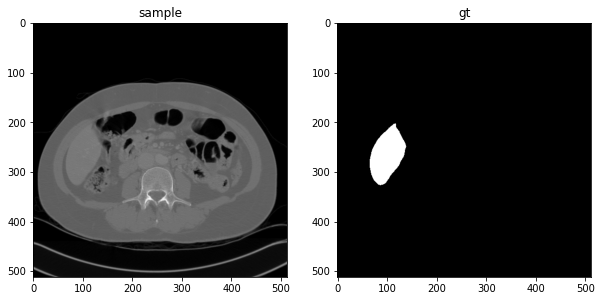

In [ ]:
fig = plt.figure(figsize=(10, 7))
fig.add_subplot(1, 2, 1)
plt.imshow(test_samples[15,:,:,0], cmap='gray')
plt.title("sample")
fig.add_subplot(1,2, 2)
plt.imshow(test_gts[15,:,:], cmap='gray')
plt.title("gt")

In [ ]:
test_samples[0:1,:,:,0:1].shape

(1, 512, 512, 1)

In [ ]:
pred = model_2.predict(test_samples[15:16,:,:,0:1])

In [ ]:
pred.shape

(1, 512, 512, 1)

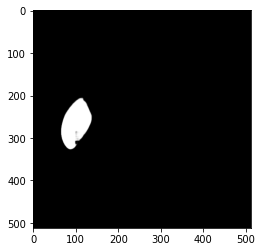

In [ ]:
plt.imshow(pred[0,:,:,0], cmap='gray')

In [ ]:
m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(pred[:,:,:,0], test_gts[15:16,:,:])
m.result().numpy()

0.6017388

In [ ]:
y_test.shape
test_sample_gt = y_test[29:30,:,:,0:1]
test_sample_gt.shape

(1, 512, 512, 1)

In [ ]:
pred.shape

(1, 512, 512, 1)

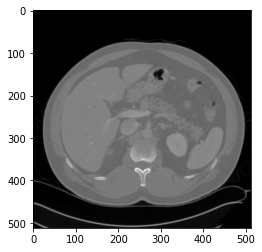

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test_sample[0,:,:,0], cmap='gray')

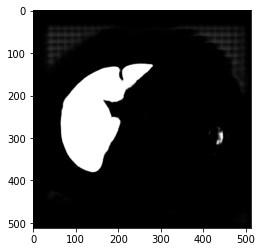

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(pred[0,:,:,0], cmap='gray')

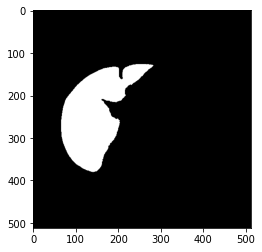

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(test_sample_gt[0,:,:,0], cmap='gray')